In [40]:
"""""""""
Written by Mengzhan Liufu and Sameera Shridhar at Yu Lab, the University of Chicago, November 2021
"""""""""
import Ipynb_importer

In [41]:
import TrodesReader
from collections import deque
import numpy as np
import math
from scipy import signal
import matplotlib.pyplot as plt

## Filter and RMS functions

In [42]:
def bandpass_filter(filter_name, flattened_array, sampling_freq, order, lowcut, highcut):
    """
    Return a dictionary of filtered lfp data

    :param filter_name: name of the filter you want to use
    :type filter_name: string
    :param flattened_array: array of the raw lfp data
    :type flattened_array: np array
    :param sampling_freq: frequency lfp data was sampled at
    :type sampling_freq: int
    :param order: order of filter
    :type order: int
    :param lowcut: lower border of frequencies allowed to pass
    :type lowcut: int
    :param highcut: upper border of frequencies allowed to pass
    :type highcut: int

    :return: filtered lfp data
    :rtype: np array
    """
    if filter_name == 'elliptical':
        sos = signal.ellip(order, 0.01, 120, [lowcut, highcut], btype='bp', output='sos', fs=sampling_freq)
    if filter_name == 'butterworth':
        sos = signal.butter(order, [lowcut, highcut], 'bp', fs=sampling_freq, output='sos')
    if filter_name == 'cheby1':
        sos = signal.cheby1(order, 1, [lowcut, highcut], 'bp', fs=sampling_freq, output='sos')
    if filter_name == 'cheby2':
        sos = signal.cheby2(order, 15, [lowcut, highcut], 'bp', fs=sampling_freq, output='sos')

    y = signal.sosfiltfilt(sos, flattened_array)

    return y

def calculate_rms(buffer):
    """
    return the root mean-squared of a given array
    :param buffer: any array or list of number

    :return: the root mean-squared value of the array as a proxy for its power
    :rtype: float
    """
    square_summed = 0
    for k in buffer:
        square_summed += (k**2)

    return math.sqrt(square_summed/len(buffer))


def detection_with_rms(buffer, low_cut, high_cut, threshold):
    """
    :param buffer: the buffer of lfp data at current iteration
    :param low_cut: the lower bound of the frequency band of interest
    :param high_cut: the upper bound of the frequency band of interest
    :param threshold: the threshold of power for making decision/judgement

    :return: whether there is activity in freq range [low_cut, high_cut] or not
    :rtype: boolean
    """
    filtered_buffer = bandpass_filter('butterworth', buffer, lfp_sampling_rate, 1, low_cut, high_cut)
    current_rms = calculate_rms(filtered_buffer)
    #current_rms = calculate_rms(buffer)
    if current_rms >= threshold:
        return (True, current_rms)
    else:
        return (False, current_rms)
    

def detection_with_rms_nofilter(buffer, low_cut, high_cut, threshold):
    """
    :param buffer: the buffer of lfp data at current iteration
    :param low_cut: the lower bound of the frequency band of interest
    :param high_cut: the upper bound of the frequency band of interest
    :param threshold: the threshold of power for making decision/judgement

    :return: whether there is activity in freq range [low_cut, high_cut] or not
    :rtype: boolean
    """
    #filtered_buffer = bandpass_filter('butterworth', buffer, lfp_sampling_rate, 1, low_cut, high_cut)
    #current_rms = calculate_rms(filtered_buffer)
    current_rms = calculate_rms(buffer)
    if current_rms >= threshold:
        return (True, current_rms)
    else:
        return (False, current_rms)

In [43]:
lfp_sampling_rate = 1250
lfp_sampling_period = (1/1250)*(10**9)
fNQ = 600

data_path = 'X:\\Trodes\\Lab Data\\20211117_testing_5min\\20211117_testing_5min.LFP\\20211117_testing_5min.LFP_nt28ch1.dat'
timestamp_path = 'X:\\Trodes\\Lab Data\\20211117_testing_5min\\20211117_testing_5min.LFP\\20211117_testing_5min.timestamps.dat'

data = TrodesReader.readTrodesExtractedDataFile(data_path)
timestamps = TrodesReader.readTrodesExtractedDataFile(timestamp_path)

lfp_data = []
for i in data['data']:
    lfp_data.append(i[0])

<string>:69: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.


In [44]:
theta_range_filtered_data = bandpass_filter('butterworth', lfp_data, lfp_sampling_rate, 1, 4, 10)

## Whole sample buffer

In [45]:
theta_rms_history = []

for i in range(2499, len(theta_range_filtered_data)):
    theta_buffer = theta_range_filtered_data[i-2499:i]
    theta_rms_history.append(calculate_rms(theta_buffer))

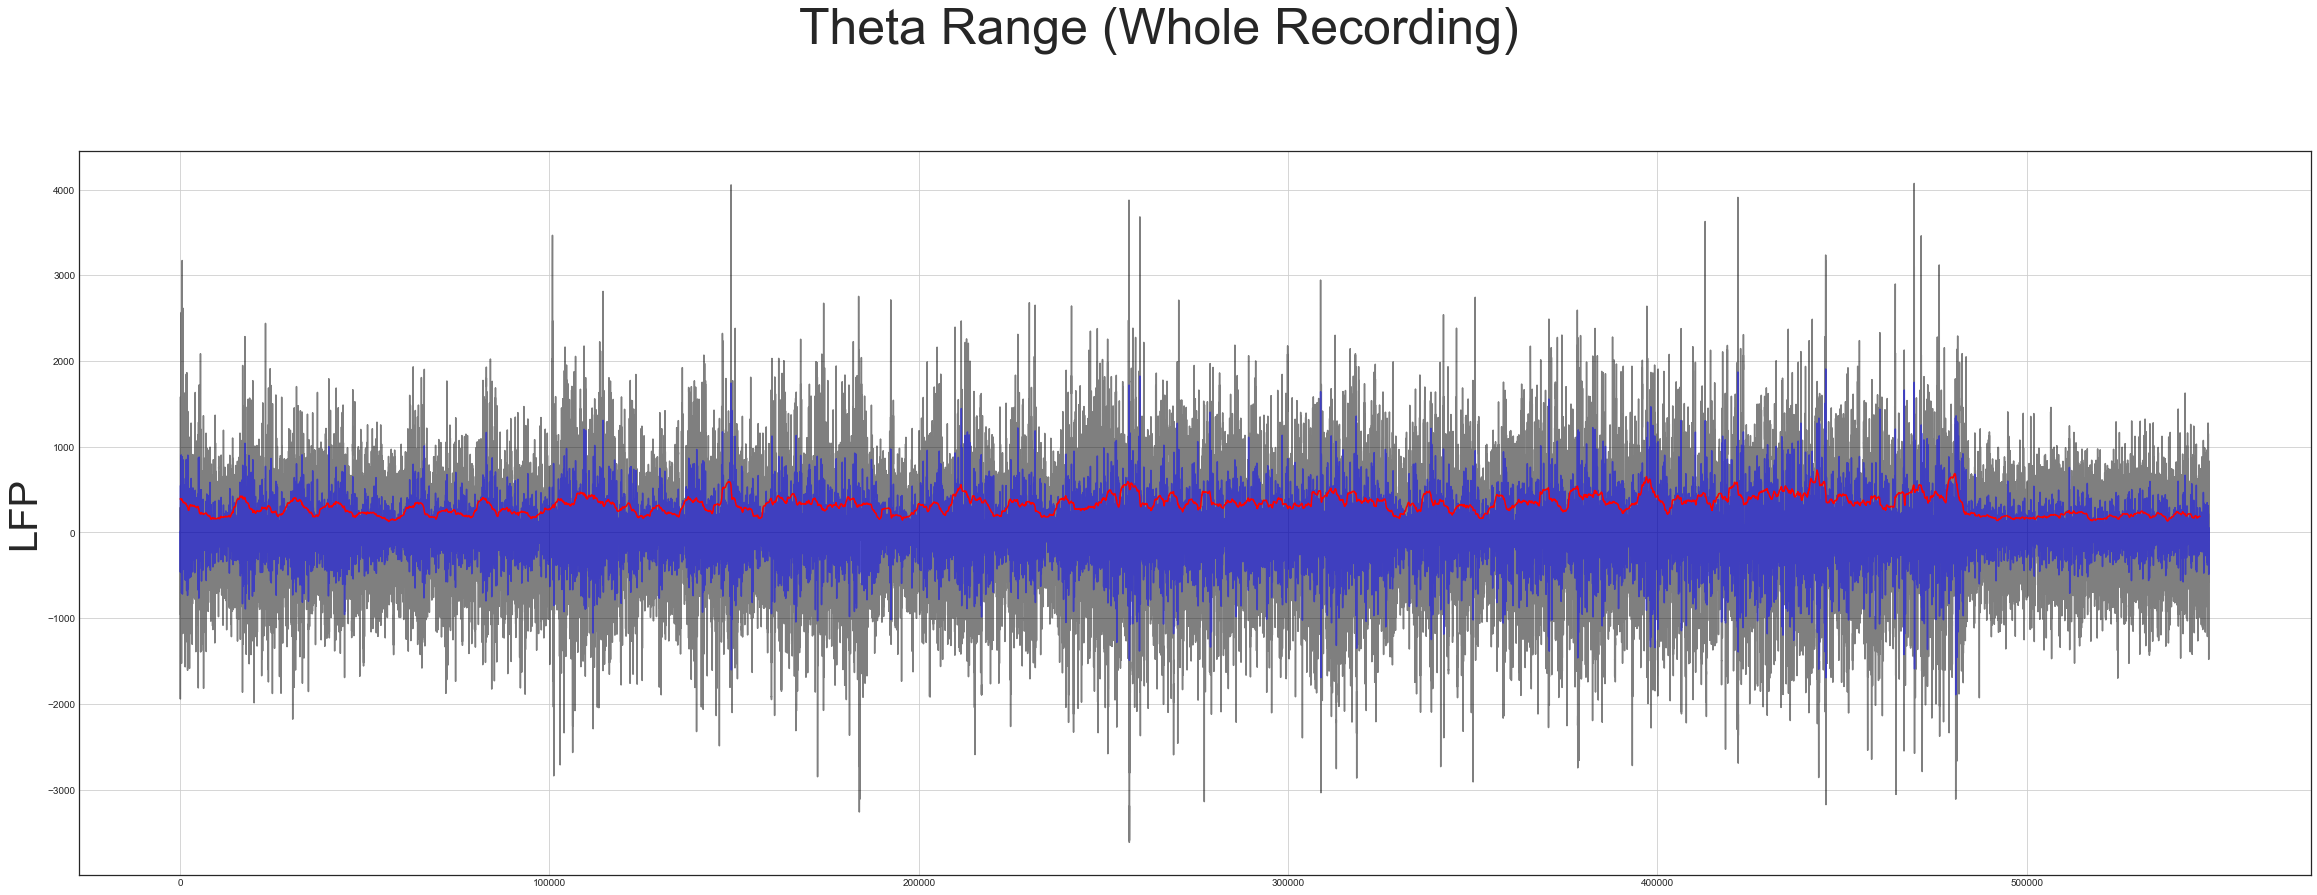

In [46]:
fig4 = plt.figure(figsize=(40,20))
grid = plt.GridSpec(6,1,wspace=0.5, hspace=0)
ax1 = plt.subplot(grid[0:4,0:1])
# ax2 = plt.subplot(grid[4:6,0:1])

ax1.plot(lfp_data,color='k',alpha=0.5)
ax1.plot(theta_range_filtered_data,color='b',alpha=0.5)
ax1.plot(theta_rms_history,color='r')
ax1.grid(True)
ax1.set_ylabel('LFP',fontsize=40)
# ax2.plot(theta_rms_history,color='r')
# ax2.grid(True)
# ax2.set_xlabel('Sample #',fontsize=40)
# ax2.set_ylabel('RMS',fontsize=40)

plt.style.use('seaborn-white')
plt.suptitle('Theta Range (Whole Recording)',fontsize=50)
plt.show()

In [59]:
theta_avg_rms = np.mean(theta_rms_history)
theta_std_rms = np.std(theta_rms_history)
theta_rms_threshold = theta_avg_rms + 3*theta_std_rms
print("Mean:",theta_avg_rms, "SD:", theta_std_rms,"Threshold:", theta_rms_threshold)

Mean: 320.47424892009036 SD: 103.64939264233641 Threshold: 631.4224268470996


## 500 sample buffer

In [61]:
theta_rms_history_short_buffer500 = []

for i in range(499,len(theta_range_filtered_data)):
    theta_buffer_short_500 = theta_range_filtered_data[i-499:i]
    theta_rms_history_short_buffer500.append(calculate_rms(theta_buffer_short_500))

In [62]:
theta_avg_rms_short_500 = np.mean(theta_rms_history_short_buffer500)
theta_std_rms_short_500 = np.std(theta_rms_history_short_buffer500)
theta_rms_threshold_short_500 = theta_avg_rms_short_500 + 3*theta_std_rms_short_500

print('Average: ' + str(theta_avg_rms_short_500))
print('Standard deviation: ' + str(theta_std_rms_short_500))
print('Threshold: ' + str(theta_rms_threshold_short_500))

Average: 307.3737170817279
Standard deviation: 137.58065257118866
Threshold: 720.1156747952939


In [63]:
# Run the detection_with_rms() function independently on raw data
theta_decision_list_short_500 = [False, False]
theta_detection_rms_history = []

theta_stimulation_list_short_500 = []

for i in range(499,len(theta_range_filtered_data)):
    buffer = lfp_data[i-499:i]
    theta_decision_short_500 = detection_with_rms(buffer,4,10,theta_rms_threshold_short_500)
    theta_decision_list_short_500.append(theta_decision_short_500[0])
    theta_detection_rms_history.append(theta_decision_short_500[1])
    
    theta_stimulation_short_500 = True
    for m in range(len(theta_decision_list_short_500)-3, len(theta_decision_list_short_500)):
        if theta_decision_list_short_500[m] == False:
            theta_stimulation_short_500 = False
    
    theta_stimulation_list_short_500.append(theta_stimulation_short_500)

In [64]:
# Run the no-filter version of detection_with_rms() to show that the filter is at work
theta_detection_rms_history_nofilter = []

for i in range(499,len(theta_range_filtered_data)):
    buffer = lfp_data[i-499:i]
    theta_decision_short_500_nofilter = detection_with_rms(buffer,4,10,theta_rms_threshold_short_500)
    theta_detection_rms_history_nofilter.append(theta_decision_short_500_nofilter[1])

In [65]:
theta_decision_list_short_500.pop(0)
theta_decision_list_short_500.pop(0)

False

<IPython.core.display.Javascript object>


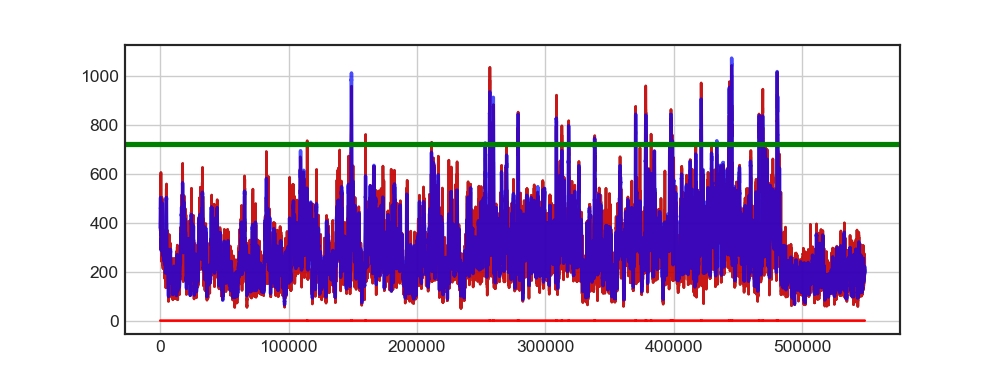

In [90]:

plt.figure(figsize=(8,3))
plt.plot(theta_detection_rms_history_nofilter,color='k',alpha=0.7,label='Detection RMS Unfiltered')
plt.plot(theta_detection_rms_history,color='r',alpha=0.7,label='Detection RMS Filtered')
plt.plot(theta_rms_history_short_buffer500, color='b',linewidth=2,alpha=0.7,label='OfflineTest RMS')
plt.axhline(y=theta_rms_threshold_short_500, color='green',linewidth = '3',label='Threshold')
# plt.legend(fontsize=6)
plt.grid(True)
# plt.ylabel('RMS',fontsize=60)
# plt.xlabel('Sample #',fontsize=60)
plt.show()

<IPython.core.display.Javascript object>


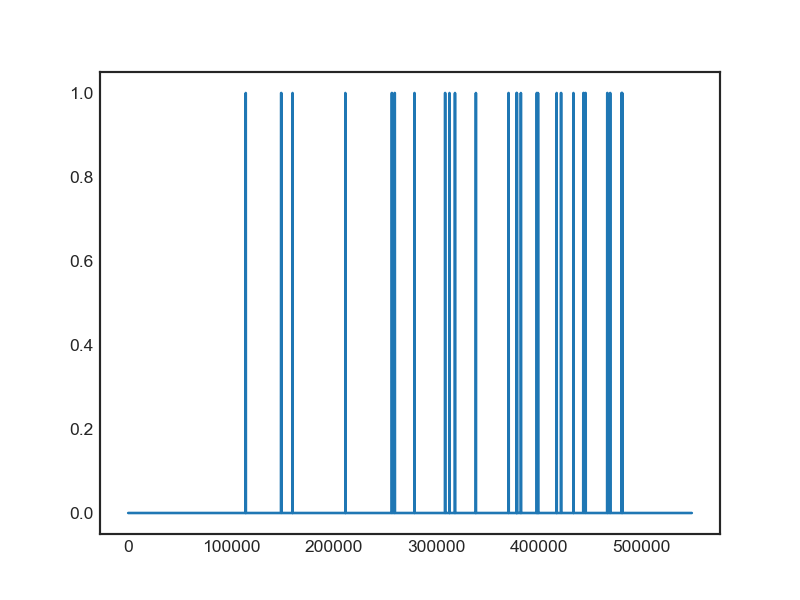

548911


In [71]:
 
plt.plot(theta_decision_list_short_500)
plt.show()
print(len(theta_decision_list_short_500))

In [91]:
 
# plt.plot(theta_stimulation_list_short_500[2000:4000],color='r')
plt.plot(theta_stimulation_list_short_500,color='r')
plt.show()

<IPython.core.display.Javascript object>


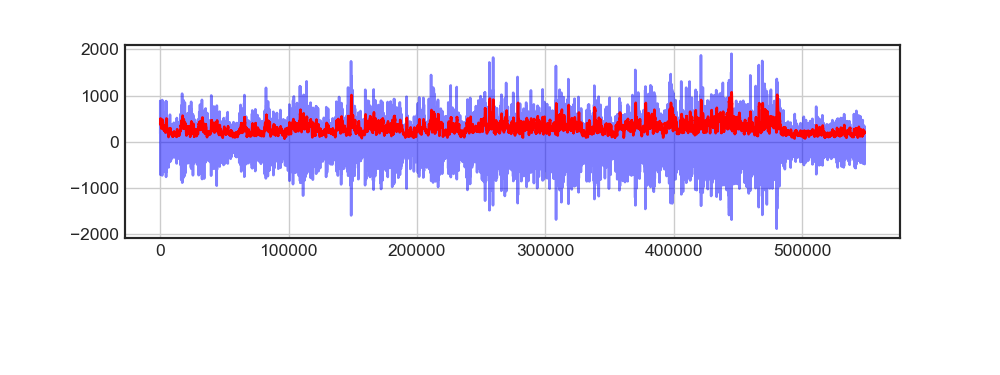

In [92]:

fig6 = plt.figure(figsize=(8,3))
grid = plt.GridSpec(6,1,wspace=0.5, hspace=0)
ax1 = plt.subplot(grid[0:4,0:1])
# ax2 = plt.subplot(grid[4:6,0:1])

ax1.plot(theta_range_filtered_data[499:len(theta_range_filtered_data)],color='b',alpha=0.5)
ax1.plot(theta_rms_history_short_buffer500,color='r')
ax1.grid(True)
# ax1.set_ylabel('Theta Range Filtered LFP',fontsize=40)
#ax2.plot(theta_rms_history_short_buffer500,color='r')
#ax2.grid(True)
# ax2.set_xlabel('Sample #',fontsize=40)
# ax2.set_ylabel('RMS',fontsize=40)

plt.style.use('seaborn-white')
# plt.suptitle('Theta Range (10s Segment/Buffers of 500 Samples)',fontsize=50)
plt.show()

<IPython.core.display.Javascript object>


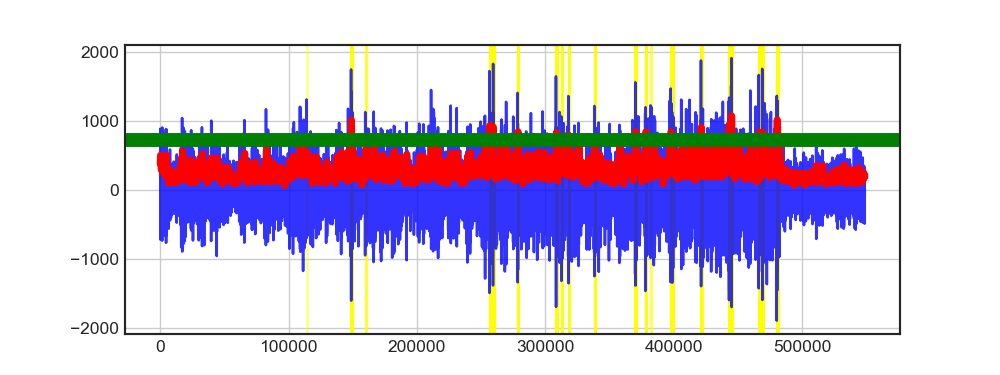

In [93]:

plt.figure(figsize=(8,3))

for s in range(0,len(theta_stimulation_list_short_500)):
    if theta_stimulation_list_short_500[s]:
        plt.axvline(x=s, color='yellow',alpha=0.5)

plt.plot(theta_range_filtered_data[499:len(theta_range_filtered_data)],color='b',alpha=0.8,label='Filtered data')
plt.plot(theta_rms_history_short_buffer500,linewidth = '4', color='r',alpha=1,label='RMS')
plt.axhline(y=theta_rms_threshold_short_500, color='green',linewidth = '8',label='Threshold')

plt.grid(True)
# plt.xlabel('Sample #',fontsize=60)
# plt.title('Theta Range Filtered Data and RMS (10s Segment/Buffers of 500 Samples)',fontsize=80)
# plt.legend(fontsize=60)
plt.show()

<IPython.core.display.Javascript object>


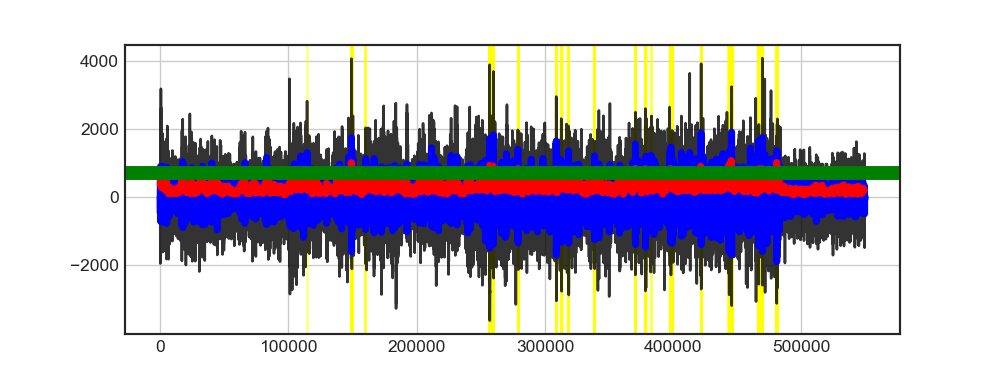

In [96]:

plt.figure(figsize=(8,3))
plt.style.use('seaborn-white')

for s in range(0,len(theta_stimulation_list_short_500)):
    if theta_stimulation_list_short_500[s]:
        plt.axvline(x=s, color='yellow',alpha=0.5)

plt.plot(lfp_data,color='k',alpha=0.8,label='Raw data')
plt.plot(theta_range_filtered_data,color='b',linewidth = '4', alpha=1,label='Filtered data')
plt.plot(theta_rms_history_short_buffer500,linewidth = '4', color='r',alpha=1,label='RMS')
plt.axhline(y=theta_rms_threshold_short_500, color='green',linewidth = '8',label='Threshold')
plt.grid(True)
# plt.title('Theta Range Raw and Filtered Data and RMS (10s Segment/Buffers of 500 Samples)',fontsize=80)
# plt.legend(fontsize=60)
# plt.xlabel('Sample #',fontsize=60)
plt.show()